In [1]:
import os
#import iris
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [9]:
#set logistical global vars
R_earth = 6367.47 #km
dphi = 0.25*np.pi/180. #radians, this is also dlambda

In [2]:
#load data
ds_grib = xr.load_dataset(
    '../cdsapi_requested_files/cds_dec07-feb08_12hrs.grib', 
    engine='cfgrib')

In [3]:
#fix indexing because the way it is done by default is stupid
index = pd.MultiIndex.from_arrays(
    [ds_grib.longitude.values, 
     ds_grib.latitude.values], 
    names=['lon', 'lat']
)
ds_grib['values'] = index
ds_grib_reshaped = ds_grib.unstack('values')
air = ds_grib_reshaped.t2m.T
ds_grib_reshaped

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/xarray/core/dataarray.py:1897: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


<xarray.Dataset>
Dimensions:     (lat: 640, lon: 11942, time: 184)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2007-12-01 ... 2008-03-01T12:00:00
    step        timedelta64[ns] 00:00:00
    surface     int64 0
    latitude    (lon, lat) float64 -89.78 -89.51 -89.23 -88.95 ... nan nan nan
    longitude   (lon, lat) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    valid_time  (time) datetime64[ns] 2007-12-01 ... 2008-03-01T12:00:00
  * lon         (lon) float64 0.0 0.2812 0.2963 0.3 ... 359.7 359.7 359.7 359.7
  * lat         (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
Data variables:
    t2m         (time, lon, lat) float32 241.62193 241.77232 ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-01-30T00:58:36 GRIB to CDM+CF via cfgrib-0....

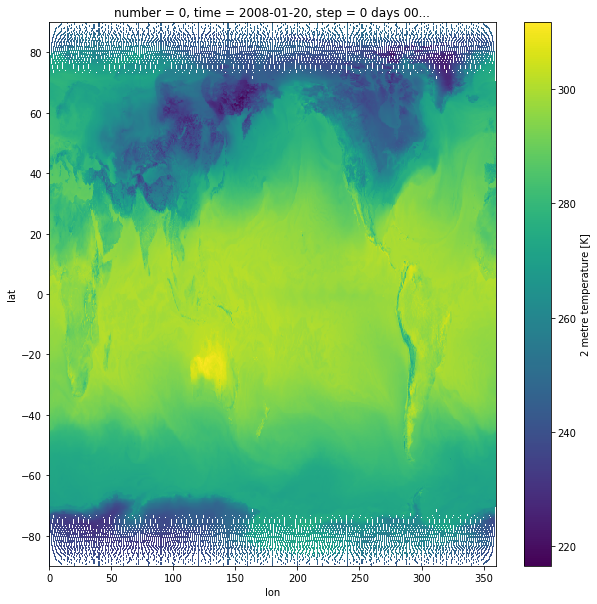

In [8]:
fig, ax = plt.subplots(figsize = (10, 10))
air.isel(time=100).plot()

In [4]:
#average each week
air_week = air.resample(time='1W').mean()
air_week_df = air_week.to_dataframe()
air_week_df = air_week_df.reset_index(drop=False).filter(['lat', 'lon', 'time', 't2m'])
Tmin = min(air_week_df.t2m)
Tmax = max(air_week_df.t2m) #kelvin
Tbins = range(int(Tmin),int(Tmax),5)

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


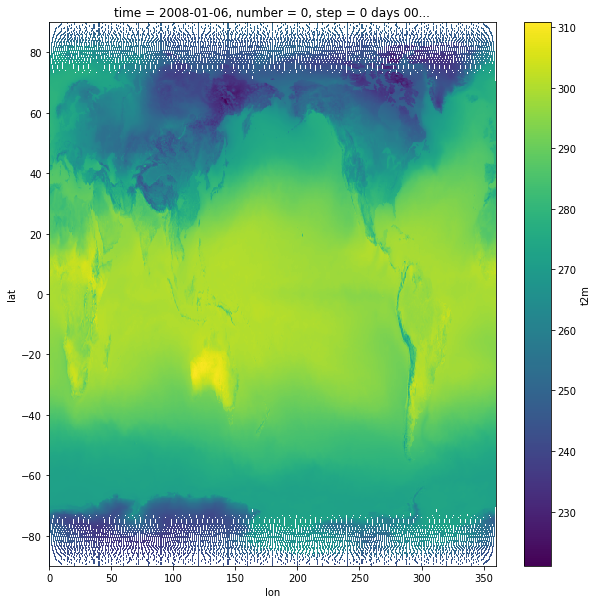

In [11]:
fig, ax = plt.subplots(figsize = (10, 10))
air_week.isel(time=5).plot() 

In [5]:
#lets just look at the first week
# first_air_week = air_week.isel(time=0)
# first_air_week_df = first_air_week.to_dataframe()
# first_air_week_df = first_air_week_df.reset_index(drop=False).filter(['lat', 'lon', 'time', 't2m'])

# Temp = first_air_week_df['t2m'][first_air_week_df['lat']>20] 
# Temp = np.linspace(Tmin,Tmax,num=100)
# Temp += np.random.normal(loc=50,scale=50, size=100)

#ok now look at all of the weeks
weeks = range(13)
all_weeks_df =air_week.isel(time=weeks).to_dataframe().reset_index(drop=False).filter(['lat', 'lon', 'time', 't2m'])
#put a cut to only look above ~mexico
lat_cut_bools = all_weeks_df['lat']>20 
# temp_all_weeks_df = all_weeks_df['t2m'][lat_cut_bools] 

In [6]:
def plots(binedges,pdf,cdf,ylab):
    plt.plot(binedges,pdf,label='pdf')
    plt.plot(binedges,cdf,label='cdf')
    plt.xlabel('bin edges [temp]')
    plt.ylabel(ylab)
    plt.legend()
    plt.show()
def dists_of_boxes(temp_df,plot=False):
    #number of boxes at each temp
    pdf_boxes, binedges = np.histogram(temp_df,bins=Tbins)
    #number of boxes below each temp
    cdf_boxes=np.cumsum(pdf_boxes)
    if plot:
        plots(binedges[:-1],pdf_boxes,cdf_boxes,'number of boxes')
    return binedges[:-1], pdf_boxes, cdf_boxes

#area 
def dists_of_areas(temp_df,lat,plot=False):
    #weight entry by box area so that y axis is no longer the number of boxes, but rather the area taken up by each box
    #lat = air_df['lat'][air_df['lat']>20]*np.pi/180. #np.linspace(np.pi/2.,np.pi/2.*(1-1/4.),num=100)
    #this is the area of each grid cell
    areas = (R_earth*dphi)**2 * np.cos(lat)
    pdf_areas, binedges = np.histogram(temp_df,bins=Tbins,weights=areas)
    cdf_areas=np.cumsum(pdf_areas)
    if plot:
        plots(binedges[:-1],pdf_areas,cdf_areas,'area [km^2]')

    return binedges[:-1], pdf_areas, cdf_areas

#convert area to effective latitude
def dists_of_lat_eff(cdf_areas,binedges=None,plot=False):
    """if plot is set to true, must specify binedges"""
    #A = 2piR^2 (1-sin(lat_eff))
    #so 1-A/(2piR^2) = sin(lat_eff)
    #but remember latitude is defined to start at pi at the north pole
    pdf_lat_effs = np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_earth**2) )
    cdf_lat_effs = np.cumsum(pdf_lat_effs)
    if plot:
        plots(binedges,pdf_lat_effs, pdf_lat_effs, 'effective lat')
    return pdf_lat_effs, cdf_lat_effs

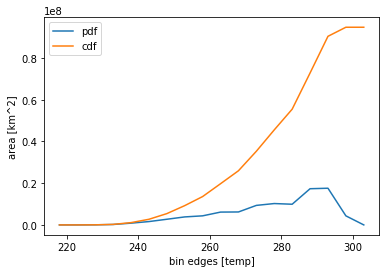

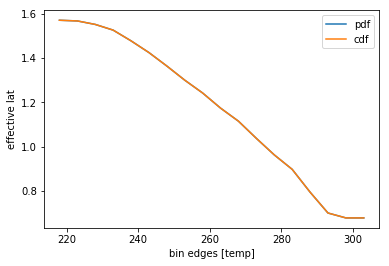

In [24]:
Temps=all_weeks_df['t2m'][lat_cut_bools] 
times = all_weeks_df['time']
lats = all_weeks_df['lat'][lat_cut_bools]*np.pi/180.

binedgs, pdf_area,cdf_area = dists_of_areas(Temps[times==times[0]],lats[times==times[0]],plot=True)
pdf_l_eff, cdf_l_eff = dists_of_lat_eff(cdf_area,binedges=binedgs,plot=True)

In [25]:
cdf_l_eff

array([ 1.57079633,  3.13846821,  4.69041022,  6.21669043,  7.69454222,
        9.11946789, 10.48363992, 11.78405619, 13.02650667, 14.2008476 ,
       15.31616781, 16.35399866, 17.31730815, 18.21542794, 19.01066482,
       19.71165282, 20.39052765, 21.06940248])

In [12]:
binedgs

array([218, 223, 228, 233, 238, 243, 248, 253, 258, 263, 268, 273, 278,
       283, 288, 293, 298, 303])

In [11]:
cdf_area

array([0.00000000e+00, 1.24345111e+03, 4.52785594e+04, 2.52375020e+05,
       1.09955965e+06, 2.70551112e+06, 5.41877087e+06, 9.25519620e+06,
       1.36094762e+07, 1.97595232e+07, 2.59713011e+07, 3.53327313e+07,
       4.55785077e+07, 5.54954993e+07, 7.28509067e+07, 9.04430135e+07,
       9.47878486e+07, 9.47878486e+07])

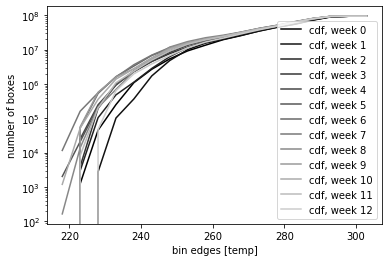

In [58]:
pdf = np.zeros([len(weeks),len(Tbins)-1])
cdf = np.zeros([len(weeks),len(Tbins)-1])
colors = np.linspace(0,0.8,num=len(weeks),dtype=str)
for w in weeks:
    timestamp = times[w]
    this_week_temp = Temps[times==timestamp]
    x,pdf[w,:],cdf[w,:] = dists_of_areas(this_week_temp,lats[times==timestamp])
    plt.plot(x,cdf[w],label='cdf, week %i'%w,c=colors[w])
plt.legend()
plt.xlabel('bin edges [temp]')
plt.ylabel('area [km^2]')
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(lat,Temp, marker=',',alpha=0.001)
plt.xlabel('latitude [deg]')
plt.ylabel('temperature [K]')
plt.show()

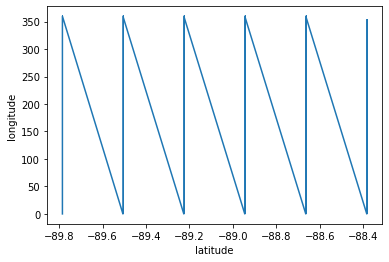

In [29]:
plt.plot(lat[:1000000],air_week_df['lon'][:1000000],marker=',')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

In [14]:
print(air.groupby(['time'], as_index=False)['t2m'].count())

         time     t2m
0  2007-12-02  542080
1  2007-12-09  542080
2  2007-12-16  542080
3  2007-12-23  542080
4  2007-12-30  542080
5  2008-01-06  542080
6  2008-01-13  542080
7  2008-01-20  542080
8  2008-01-27  542080
9  2008-02-03  542080
10 2008-02-10  542080
11 2008-02-17  542080
12 2008-02-24  542080
13 2008-03-02  542080


In [53]:
#angular resolution (lon) of reported temp data is coarser at poles (Every 20deg) than at mid-lat (~every 2 deg). 
#at equator, its every 0.33? deg
#this makes sense because it would be pretty expensive to have it every 0.25 deg at poles!
first_air_week_df.lon[np.logical_not(np.isnan(first_air_week_df.t2m))][129600:129670]
#print(np.sum(np.logical_not(np.isnan(first_air_week_df.t2m))),len(first_air_week_df.t2m))

2465393    160.96
2465404    161.28
2465413    161.60
2465423    161.92
2465432    162.24
            ...  
2466082    181.76
2466092    182.08
2466102    182.40
2466113    182.72
2466123    183.04
Name: lon, Length: 70, dtype: float64